# 實作PGGAN演算法，產生名人臉部
### 程式修改自[Generate Artificial Faces with CelebA Progressive GAN Model](https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module)

In [ ]:
!pip install scikit-image

## 載入相關套件

In [1]:
# 載入相關套件
from absl import logging
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

## 定義顯示圖像的函數、轉為動畫的函數

In [2]:
# 生成網路的輸入向量尺寸
latent_dim = 512

# 定義顯示圖像的函數
def display_image(image):
    image = tf.constant(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return PIL.Image.fromarray(image.numpy())

# 定義顯示一序列圖像轉為動畫的函數
from tensorflow_docs.vis import embed
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    return embed.embed_file('./animation.gif')

# 工作記錄檔只記錄錯誤等級以上的訊息
logging.set_verbosity(logging.ERROR)

## 載入預先訓練好的模型

In [3]:
# 載入預先訓練好的模型
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

## 插補兩向量，產生動畫


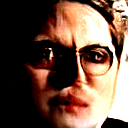

In [4]:
# 在超球面上插補兩向量
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

# 插補兩向量
def interpolate_between_vectors():
    # 產生兩個雜訊向量
    v1 = tf.random.normal([latent_dim])
    v2 = tf.random.normal([latent_dim])

    # 產生 25 個步驟的插補
    vectors = interpolate_hypersphere(v1, v2, 50)

    # 產生一序列的圖像
    interpolated_images = progan(vectors)['default']
    return interpolated_images

# 插補兩向量，產生動畫
interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

## 使用隨機亂數或自訂的圖像

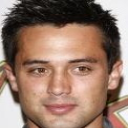

In [12]:
# 使用自訂的圖像
image_path='./images_face/000007.jpg'

# True：使用隨機亂數，False：使用自訂的圖像
image_from_module_space = False    

tf.random.set_seed(0)

def get_module_space_image():
    vector = tf.random.normal([1, latent_dim])
    images = progan(vector)['default'][0]
    return images

# 使用隨機亂數
if image_from_module_space:
    target_image = get_module_space_image()
else: # 使用自訂的圖像
    image = imageio.imread(image_path)
    target_image = transform.resize(image, [128, 128])

# 顯示圖像    
display_image(target_image)

## 以PGGAN 處理的圖像作為起始圖像

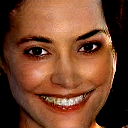

In [13]:
# 以PGGAN 處理的圖像作為起始圖像
initial_vector = tf.random.normal([1, latent_dim])

# 顯示圖像 
display_image(progan(initial_vector)['default'][0])

## 找到最接近的特徵向量，漸變成第二張圖像

In [19]:
# 找到最接近的特徵向量
def find_closest_latent_vector(initial_vector, num_optimization_steps,                                                             steps_per_image):
    images = []
    losses = []

    vector = tf.Variable(initial_vector)    
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    # 以 MAE 為損失函數
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

    # 訓練
    for step in range(num_optimization_steps):
        if (step % 100)==0:
            print()
        print('.', end='')
        
        # 梯度下降
        with tf.GradientTape() as tape:
            image = progan(vector.read_value())['default'][0]
            
            # 每 5 步驟產生一個圖像
            if (step % steps_per_image) == 0:
                img = tf.keras.preprocessing.image.array_to_img(image.numpy())
                img.save(f"./PGGAN_generated/img_{step:03d}.png")
                images.append(image.numpy())
            
            # 計算損失
            target_image_difference = loss_fn(image, target_image[:,:,:3])
            # 正則化
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
            loss = tf.cast(target_image_difference, tf.double) + tf.cast(regularizer, tf.double)
            losses.append(loss.numpy())

        # 根據梯度，更新權重
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))

    return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

## 顯示訓練過程的損失函數

(0.0, 5996.578368473053)

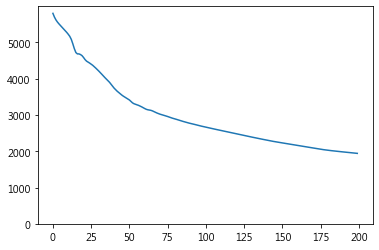

In [15]:
# 顯示訓練過程的損失函數
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])

## 顯示動畫


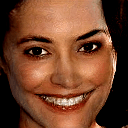

In [16]:
animate(np.stack(images))